# CMIP6 global projections

Experimental showcase for getting CMIP6 climate data with [Intake-esm](https://intake-esm.readthedocs.io/en/latest/).  The following packages are used:

- [Intake-esm](https://intake-esm.readthedocs.io/en/latest/): an intake plugin for parsing an Earth System Model (ESM) catalog and loading assets into xarray datasets.
- [xarray](http://xarray.pydata.org/en/stable/) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! ([Xarray Tutorial](https://xarray-contrib.github.io/xarray-tutorial/) / [Xarray | SciPy 2020](https://www.youtube.com/watch?v=mecN-Ph_-78&list=PLYx7XA2nY5Gde-6QO98KUJ9iL_WW4rgYf&index=4))
- [ProPlot](https://proplot.readthedocs.io/en/latest/): a lightweight matplotlib wrapper for making beautiful, publication-quality graphics. 
(still in development)
- [xESMF](https://xesmf.readthedocs.io/en/latest/): Universal Regridder for Geospatial Data (only for Linux and Mac, an alternative is the [interp](http://xarray.pydata.org/en/stable/interpolation.html#example) function from xarray)
- [Dask](https://dask.org/) provides advanced parallelism for analytics ([jacobtomlinson/dask-video-tutorial-2020](https://github.com/jacobtomlinson/dask-video-tutorial-2020) / [Dask | SciPy 2020](https://www.youtube.com/watch?v=EybGGLbLipI&list=PLYx7XA2nY5Gde-6QO98KUJ9iL_WW4rgYf&index=6))

## Climate analysis

The purpose of this analysis will be to make a figure of the time series over the historical period, as well as projections for future scenarios.


## Where is this running?

This session is running on [binder.pangeo.io](https://binder.pangeo.io),
a service designed and maintained by the [Pangeo community](https://pangeo.io) for scalable earth science.
It is running on Google Cloud Platform using credits generously donated by Google to that Community.


# Import packages

In [1]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

# Make a Dask cluster for parallelization

![](img/dask.png)

Click on the Dask icon (image above) in the left toolbar. Click on the `+ NEW` button, then right-click on the LocalCluster that will appear below and click on `Inject Dask Client Connection Code`. You should have a cell similar to the one below. Otherwise you can just copy the `Scheduler Address` and replace it in the cell below.

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45789")
client

Client Scheduler: tcp://127.0.0.1:45789 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.33 GB


You can then display the `WORKERS`, `PROGRESS` and `TASK STREAM` for example to get an overview of how the tasks will be parallelized.

# Get observations
HadCRUT4 is a global temperature dataset, providing gridded temperature anomalies across the world as well as averages for the hemispheres and the globe as a whole. CRUTEM4 and HadSST3 are the land and ocean components of this overall dataset, respectively.

These datasets have been developed by the Climatic Research Unit (University of East Anglia) in conjunction with the Hadley Centre (UK Met Office), apart from the sea surface temperature (SST) dataset which was developed solely by the Hadley Centre. These datasets will be updated at roughly monthly intervals into the future. Hemispheric and global averages as monthly and annual values are available as separate files.

https://crudata.uea.ac.uk/cru/data/temperature/

In [3]:
obs = xr.open_dataset('data/HadCRUT.4.6.0.0.median.nc').temperature_anomaly
obs

<xarray.DataArray 'temperature_anomaly' (time: 2048, latitude: 36, longitude: 72)>
[5308416 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2020-08-16T12:00:00
Attributes:
    long_name:         near_surface_temperature_anomaly
    units:             K
    reference_period:  [1961 1990]

# Get CMIP6 data
This is made easier thanks to the [Intake-esm](https://intake-esm.readthedocs.io/en/latest/) package in combination with the [Pangeo](https://pangeo.io/) project and [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) (still quite experimental)! Otherwise you have to download the data from https://esgf-node.llnl.gov/search/cmip6/ (official international database, but this is much more tedious).

See the [Intake-esm tutorial](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html) for more informations.

In [7]:
# Get the catalog of CMIP6 data

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,15
institution_id,34
source_id,79
experiment_id,107
member_id,214
table_id,30
variable_id,394
grid_label,10
zstore,315272
dcpp_init_year,60


In [5]:
# Select he first member of Near-Surface Air Temperature (tas) 
# for the historical and future scenarios exepriments

cat = col.search(
    activity_id=['CMIP', 'ScenarioMIP'],
    experiment_id=['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
    table_id="Amon",
    variable_id="tas",
    member_id="r1i1p1f1"
)

cat

,unique
activity_id,2
institution_id,30
source_id,48
experiment_id,5
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,161
dcpp_init_year,0


In [9]:
# Visualize it (no data is loaded yet)

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i...,NaN,20200623
1,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN,20200720
2,CMIP,AWI,AWI-ESM-1-1-LR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/...,NaN,20200212
3,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...,NaN,20181126
4,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...,NaN,20181214
...,...,...,...,...,...,...,...,...,...,...,...
156,ScenarioMIP,NUIST,NESM3,ssp245,r1i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NUIST/NESM3/ssp245/r1i1...,NaN,20190731
157,ScenarioMIP,NUIST,NESM3,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1...,NaN,20190728
158,ScenarioMIP,THU,CIESM,ssp126,r1i1p1f1,Amon,tas,gr,gs://cmip6/ScenarioMIP/THU/CIESM/ssp126/r1i1p1...,NaN,20200417
159,ScenarioMIP,THU,CIESM,ssp245,r1i1p1f1,Amon,tas,gr,gs://cmip6/ScenarioMIP/THU/CIESM/ssp245/r1i1p1...,NaN,20200417


In [11]:
# Get the data in a dictionnary of lazy* Dataset
# *http://xarray.pydata.org/en/stable/dask.html

dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


# Time series computation

Let's calculate the time series for each of the models and experiments as well as the climatology over the reference period. The results will be stored in a DataFrame.

Note that all operations are actually not calculated here. Dask only creates calculation graphs under the hood to optimize the calculations in parallel while respecting the allocated memory.

In [63]:
period_future = slice('2015','2100')
period_past = slice('1850','2014')

n_months_future = (int(period_future.stop) - int(period_future.start) + 1) * 12
n_months_past = (int(period_past.stop) - int(period_past.start) + 1) * 12

columns = ['clim', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
df = pd.DataFrame(index=[], columns=columns)

for key in list(dset_dict.keys())[:]:
# for key in ["ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp126.Amon.gr"]:
    
#     print(key)
    
    model = key.split('.')[2]
    experiment = key.split('.')[3]
    
    # Get the dataset
    ds = dset_dict[key]
    
    # Preformat data
    if ('latitude' in ds.coords):
        ds = ds.rename({'latitude': 'lat'})
    if ('longitude' in ds.coords):
        ds = ds.rename({'longitude': 'lon'})
    if ('height' in ds.coords):
        ds = ds.drop('height')
    
    try:
        # Historical
        if experiment == 'historical':
            da = ds.sel(member_id='r1i1p1f1', time=period_past).tas - 273.15
            
        # Futur scenarios
        elif experiment in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
            da = ds.sel(member_id='r1i1p1f1', time=period_future).tas - 273.15
            
        try:
            # Check time
            if experiment == 'historical':
                np.testing.assert_equal(n_months_past, da.time.size)
            elif experiment in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
                np.testing.assert_equal(n_months_future, da.time.size)            
            
            # Make global spatial average
            weights = np.cos(np.deg2rad(da.lat))
            da_weighted = da.weighted(weights)
            global_mean = da_weighted.mean(dim=('lat', 'lon'))
            
            # Resample by years
            global_mean_year = global_mean.groupby('time.year').mean('time')     
            
            # Store results
            if model in df.index:
                df[experiment][model] = global_mean_year
            else:
                temp = pd.DataFrame(index=[model], columns=columns)
                temp[experiment][model] = global_mean_year
                df = df.append(temp)
                
            # Compute climatology for reference period (to compute anomalies)
            if experiment == 'historical':
                clim = global_mean_year.sel(
                    year=slice(str(obs.reference_period[0]), str(obs.reference_period[1]))
                ).mean('year')
                df.clim[model] = clim
            
        except AssertionError:
            print(key + ' does not have all the period available!')
            
    except KeyError:
        print(key + ' KeyError raised (might not have the actual period: '+str(ds['time.year'][0].values)+'-'+str(ds['time.year'][-1].values)+').')
            

ScenarioMIP.CAMS.CAMS-CSM1-0.ssp245.Amon.gn does not have all the period available!
ScenarioMIP.NCC.NorESM2-LM.ssp370.Amon.gn KeyError raised (might not have the actual period: 2091-2050).
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp245.Amon.gn does not have all the period available!
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp126.Amon.gn does not have all the period available!
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn does not have all the period available!
ScenarioMIP.NCC.NorESM2-LM.ssp245.Amon.gn KeyError raised (might not have the actual period: 2031-2030).
ScenarioMIP.NCC.NorESM2-LM.ssp126.Amon.gn KeyError raised (might not have the actual period: 2031-2020).
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp370.Amon.gn does not have all the period available!
ScenarioMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.ssp370.Amon.gn does not have all the period available!
ScenarioMIP.NCC.NorESM2-MM.ssp126.Amon.gn KeyError raised (might not have the actual period: 2071-2090).
CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn does not have

## Visualize computation graph
https://docs.dask.org/en/latest/graphviz.html

### DataArray selection
`da = ds.sel(member_id='r1i1p1f1', time=period_past).tas - 273.15`

In [64]:
da

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<sub, shape=(1032, 144, 192), dtype=float32, chunksize=(516, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    member_id  <U8 'r1i1p1f1'

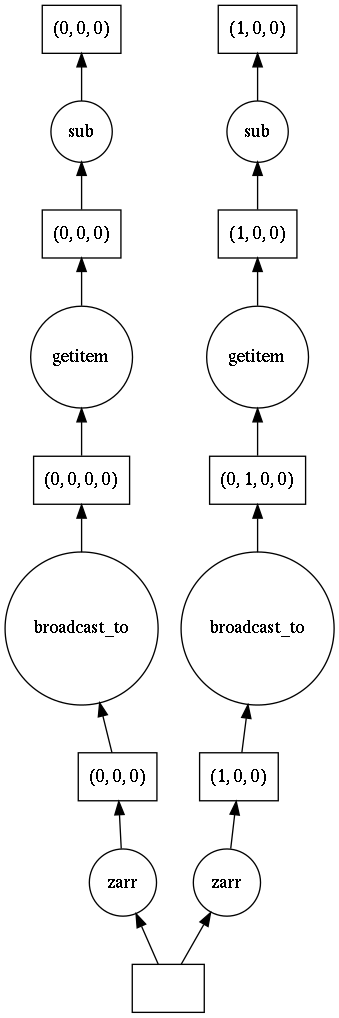

In [65]:
da.data.visualize()

### Global Mean
`global_mean = da_weighted.mean(dim=('lat', 'lon'))`

In [66]:
global_mean

<xarray.DataArray (time: 1032)>
dask.array<truediv, shape=(1032,), dtype=float64, chunksize=(516,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
    member_id  <U8 'r1i1p1f1'

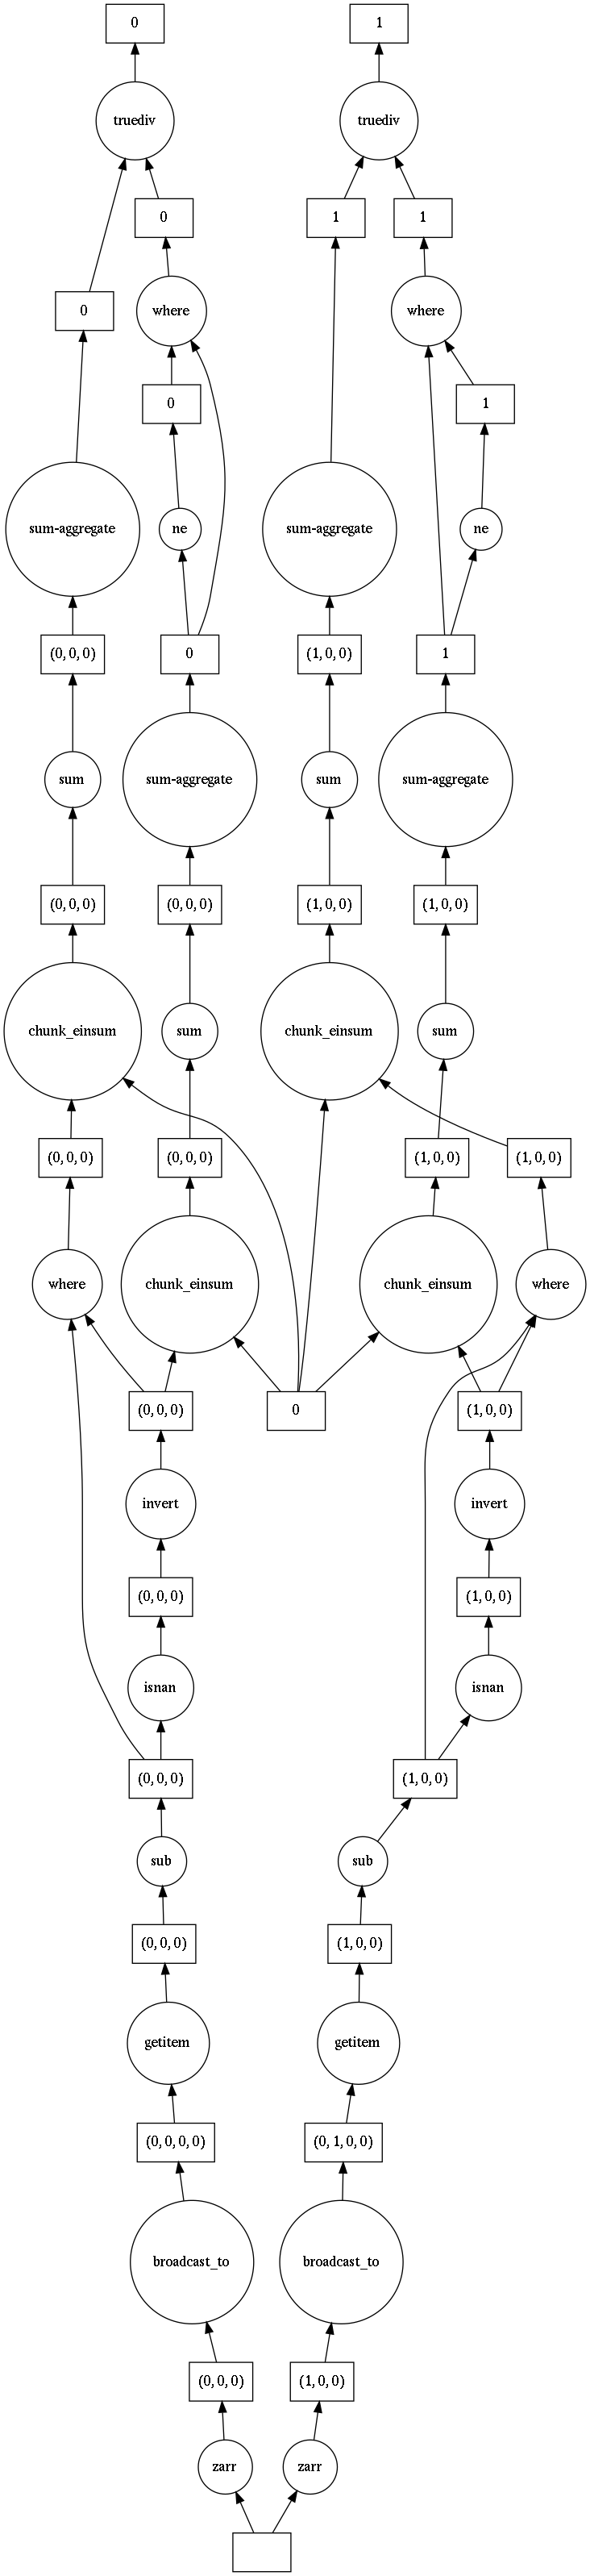

In [67]:
global_mean.data.visualize()

## Visualize DataFrame

In [13]:
df

,clim,historical,ssp126,ssp245,ssp370,ssp585
INM-CM5-0,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
ACCESS-ESM1-5,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
MRI-ESM2-0,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
FIO-ESM-2-0,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...",NaN,"[<xarray.DataArray ()>\ndask.array<getitem, sh..."
GFDL-CM4,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...",NaN,"[<xarray.DataArray ()>\ndask.array<getitem, sh...",NaN,"[<xarray.DataArray ()>\ndask.array<getitem, sh..."
AWI-CM-1-1-MR,NaN,NaN,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
FGOALS-f3-L,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
IPSL-CM6A-LR,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."
CIESM,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...",NaN,"[<xarray.DataArray ()>\ndask.array<getitem, sh..."
INM-CM4-8,<xarray.DataArray ()>\ndask.array<mean_agg-agg...,"[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh...","[<xarray.DataArray ()>\ndask.array<getitem, sh..."


# Removes models for which climatology is not available

In [69]:
df = df[df['clim'].notna()]

# Concatenate experiments and make computation (only now!)
See this link for more information about Dask computation: https://distributed.dask.org/en/latest/manage-computation.html

Here we use `.load()` that will load the result into memory and implicitly will make `.compute()`.

In [70]:
df.columns

Index(['clim', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'], dtype='object')

In [71]:
clim = xr.concat(df.clim, pd.Index(df.clim.index, name='model')).load()
hist = xr.concat(df.historical, pd.Index(df.historical.index, name='model')).load()
ssp126 = xr.concat(df.ssp126.dropna(), pd.Index(df.ssp126.dropna().index, name='model')).load()
ssp245 = xr.concat(df.ssp245.dropna(), pd.Index(df.ssp245.dropna().index, name='model')).load()
ssp370 = xr.concat(df.ssp370.dropna(), pd.Index(df.ssp370.dropna().index, name='model')).load()
ssp585 = xr.concat(df.ssp585.dropna(), pd.Index(df.ssp585.dropna().index, name='model')).load()

In [36]:
clim

<xarray.DataArray (model: 46)>
array([13.49433167, 14.57684957, 13.92401491, 13.78927017, 12.83517225,
       13.18554759, 13.37410164, 14.91435557, 13.69428617, 14.36591005,
       14.21326342, 13.88897115, 13.87020245, 13.88932422, 13.366908  ,
       14.08595617, 13.82319117, 15.45186582, 13.92392082, 14.2404776 ,
       14.35037603, 14.05719622, 13.18953518, 14.55118139, 13.22148063,
       13.73772413, 14.92909787, 12.75870012, 13.55283392, 13.98865349,
       13.89940171, 14.77249746, 14.15510653, 13.84148213, 14.57580774,
       13.49546511, 13.57470208, 14.56346181, 14.31972509, 14.17193894,
       13.95459678, 14.46397448, 14.49884066, 13.91119852, 13.90757797,
       13.82625451])
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * model      (model) object 'INM-CM5-0' 'ACCESS-ESM1-5' ... 'MCM-UA-1-0'

# Compute anomalies

In [72]:
hist = (hist - clim.load())
ssp126 = (ssp126 - clim.where(clim.model == ssp126.model))
ssp245 = (ssp245 - clim.where(clim.model == ssp245.model))
ssp370 = (ssp370 - clim.where(clim.model == ssp370.model))
ssp585 = (ssp585 - clim.where(clim.model == ssp585.model))

# Make ensemble median and quantile

In [73]:
def compute_median_quantile(da):
    da_median = da.median('model').compute()
    da_quantile = da.quantile([0.25, 0.75], dim='model').compute()
    
    return da_median, da_quantile

In [74]:
hist_median, hist_quantile = compute_median_quantile(hist)
ssp126_median, ssp126_quantile = compute_median_quantile(ssp126)
ssp245_median, ssp245_quantile = compute_median_quantile(ssp245)
ssp370_median, ssp370_quantile = compute_median_quantile(ssp370)
ssp585_median, ssp585_quantile = compute_median_quantile(ssp585)

In [101]:
ssp = [ssp126, ssp245, ssp370, ssp585]
ssp_median = [ssp126_median, ssp245_median, ssp370_median, ssp585_median]
ssp_quantile = [ssp126_quantile, ssp245_quantile, ssp370_quantile, ssp585_quantile]

# Make global mean of obs

In [87]:
coslat = np.cos(np.deg2rad(obs.latitude)).where(~obs.isnull())
weights = coslat / coslat.sum(dim=('latitude', 'longitude'))
obs_weighted = (obs * weights).sum(dim=('latitude', 'longitude'))

In [112]:
obs_median = obs_weighted.groupby('time.year').mean('time')

# Plot it!

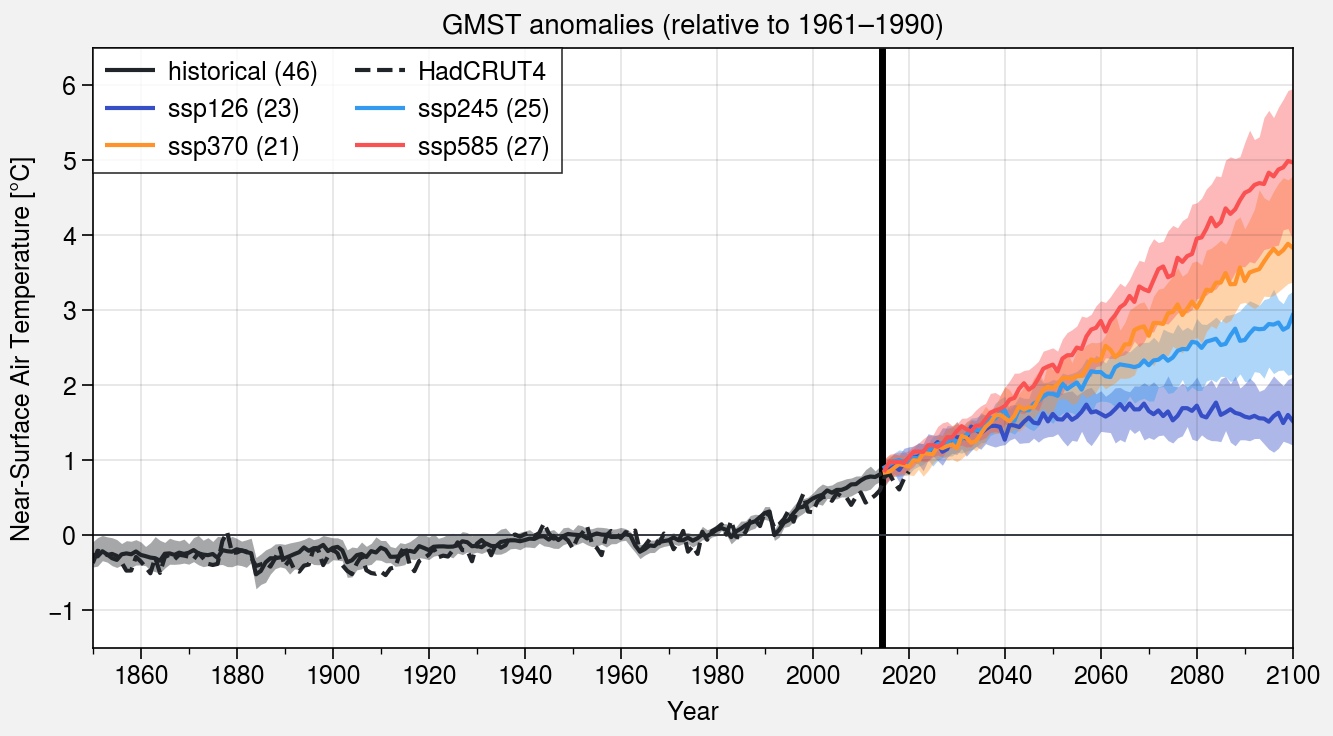

In [118]:
fig, ax = plot.subplots(aspect=2, axwidth=6)

ymin = -1.5
ymax = 6.5

# Models past
h_past = ax.plot(hist_median, shadedata=hist_quantile, 
                 label='historical ('+str(hist.model.size)+')', color='gray9')

# Obs
h_obs = ax.plot(obs_median, 
                label='HadCRUT4', color='gray9', linestyle='--')

# Models future
colors = ['indigo9', 'blue5', 'orange5', 'red6']
scenarios = columns[2:]
h_future = [None]*len(scenarios)

for i, scenario in enumerate(scenarios):
    h_future[i] = ax.plot(ssp_median[i], shadedata=ssp_quantile[i], 
                          label=scenario+' ('+str(ssp[i].model.size)+')', color=colors[i])

# Lines
ax.vlines(2014.5, ymin, ymax, linewidth=2.5)
ax.hlines(0, 1850, 2100, linewidth=0.7, color='gray8')

# Legend / Format
ax.legend(
    [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
    loc='ul', frame=True, ncols=2
)

ax.format(
    title='GMST anomalies (relative to '+str(obs.reference_period[0])+'–'+str(obs.reference_period[1])+')',
    ylabel='Near-Surface Air Temperature [°C]', ylocator=1, yminorlocator=1.00001, ylim=(ymin,ymax),
    xlabel='Year', xminorlocator=10, xlocator=20
)

filename = 'GMST_anomalies'
for ext in ['jpg', 'png', 'pdf']:
    fig.save('img/'+filename+'.'+ext)